In [1]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_coe = pd.read_csv('M11-coe_results.csv')

In [3]:
df_coe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   month          1310 non-null   object
 1   bidding_no     1310 non-null   int64 
 2   vehicle_class  1310 non-null   object
 3   quota          1310 non-null   int64 
 4   bids_success   1310 non-null   int64 
 5   bids_received  1310 non-null   int64 
 6   premium        1310 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 71.8+ KB


Looking at ONLY Cat A:

In [4]:
df_cat_a=df_coe[df_coe["vehicle_class"]=="Category A"]
df_cat_a=df_cat_a.reset_index(drop=True)

In [5]:
df_cat_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   month          262 non-null    object
 1   bidding_no     262 non-null    int64 
 2   vehicle_class  262 non-null    object
 3   quota          262 non-null    int64 
 4   bids_success   262 non-null    int64 
 5   bids_received  262 non-null    int64 
 6   premium        262 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 14.5+ KB


Set bidding made on 1st Monday of week to be 1, 3rd Monday of week: 15

In [6]:
print(df_cat_a["month"][0]+"-01")

2010-01-01


In [7]:
i=0
length_df=len(df_cat_a)
while(i<length_df):
    if(i%2==0):
        df_cat_a["month"][i]=df_cat_a["month"][i]+"-01"
    else:
         df_cat_a["month"][i]=df_cat_a["month"][i]+"-15"
    i+=1

In [8]:
df_cat_a["month"]=pd.to_datetime(df_cat_a["month"])

In [9]:
df_cat_a["month"]

0     2010-01-01
1     2010-01-15
2     2010-02-01
3     2010-02-15
4     2010-03-01
         ...    
257   2020-12-15
258   2021-01-01
259   2021-01-15
260   2021-02-01
261   2021-02-15
Name: month, Length: 262, dtype: datetime64[ns]

In [10]:
print("df_coe shape:" + str(df_coe.shape))

df_coe shape:(1310, 7)


Check for missing values

In [11]:
total_null_df_coe = df_coe.isnull().sum().sort_values(ascending = False)

total_null_df_coe

premium          0
bids_received    0
bids_success     0
quota            0
vehicle_class    0
bidding_no       0
month            0
dtype: int64

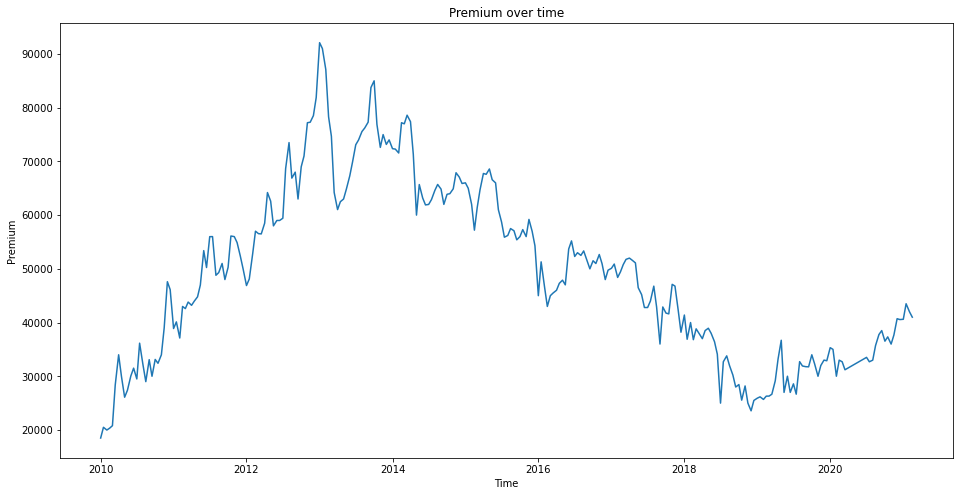

In [13]:
tp=df_cat_a.groupby(["month"])["premium"].sum()
plt.figure(figsize=(16,8))
plt.title('Premium over time')
plt.xlabel('Time')
plt.ylabel('Premium')
plt.plot(tp)

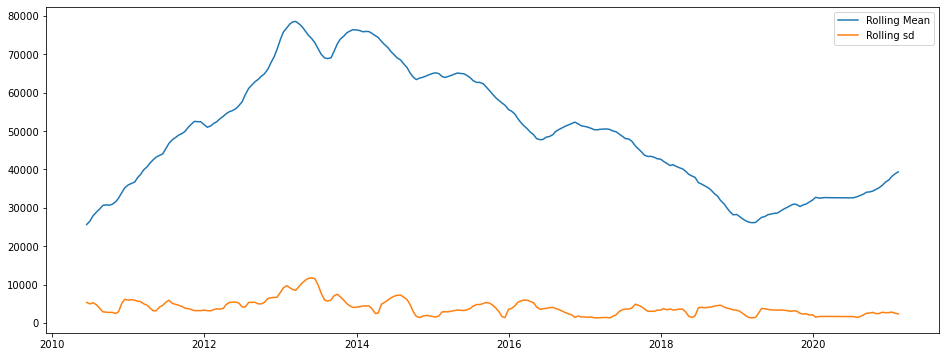

In [14]:
plt.figure(figsize=(16,6))
plt.plot(tp.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(tp.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

In [15]:
#Perform Dickey-Fuller test for cat A:
print('Results of Dickey-Fuller Test:')
premium_a=df_cat_a['premium'].values
dftest = adfuller(premium_a, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -1.596071
p-value                          0.485567
#Lags Used                       8.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


Since test statistic not lesser than critical value,  we do not reject null hypothesis. Series is non-stationary.

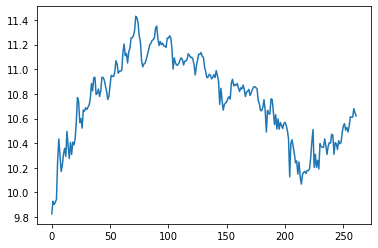

In [16]:
df_cat_a_log = np.log(premium_a)
plt.plot(df_cat_a_log)

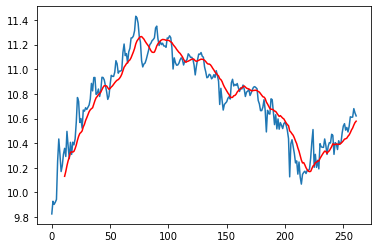

In [19]:
df_cat_a_log=pd.DataFrame(df_cat_a_log)

moving_avg = df_cat_a_log.rolling(12).mean()
plt.plot(df_cat_a_log)
plt.plot(moving_avg, color='red')

In [21]:
cat_a_log_moving_avg_diff = df_cat_a_log - moving_avg
cat_a_log_moving_avg_diff.head(12)

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


Need to drop first 11 NaN values

In [24]:
cat_a_log_moving_avg_diff

,0
11,0.226962
12,0.122202
13,0.278492
14,0.119981
15,-0.011263
...,...
257,0.103214
258,0.088533
259,0.133540
260,0.078329


In [23]:
cat_a_log_moving_avg_diff.dropna(inplace=True)
print('Results of Dickey-Fuller Test:')

dftest = adfuller(cat_a_log_moving_avg_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.009318e+00
p-value                        1.587404e-07
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


??????????????????????????????